<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211028_orenist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みフィルターを用いた画像の分類をやってみる

## ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import models, layers

np.random.seed(20211028)
tf.random.set_seed(20211028)

## 事前準備

In [4]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0    613      0 --:--:-- --:--:-- --:--:--   613
100  553k  100  553k    0     0  1263k      0 --:--:-- --:--:-- --:--:-- 1263k


In [5]:
with open('ORENIST.data', 'rb')as file:
  images, labels = pickle.load(file)

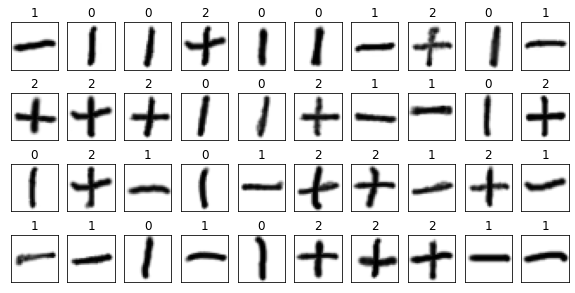

In [6]:
fig = plt.figure(figsize=(10, 5))
for i in range(40):
  subplot = fig.add_subplot(4, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

In [7]:
def edge_filter(shape=None, dtype=None):
  filter0 = np.array(
      [[2, 1, 0, -1, -2],
       [3, 2, 0, -2, -3],
       [4, 3, 0, -3, -4],
       [3, 2, 0, -2, -3],
       [2, 1, 0, -1, -2]] 
  ) / 23.0

  filter1 = np.array(
      [[2, 3, 4, 3, 2],
       [1, 2, 3, 2, 1],
       [0, 0, 0, 0, 0],
       [-1, -2, -3, -2, -1],
       [-2, -3, -4, -3, -2]] 
  ) / 23.0

  filter_array = np.zeros([5, 5, 1, 2])
  filter_array[:, :, 0, 0] = filter0
  filter_array[:, :, 0, 1] = filter1

  return filter_array

## ニューラルネットワークの定義

In [9]:
model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28, ), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same', kernel_initializer=edge_filter, use_bias=False, trainable=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(2, activation='tanh', name='hidden'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
cut_off (Lambda)             (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 14, 14, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
hidden (Dense)               (None, 2)                

`conv_filter`の`trainable=False`によりこの層のパラメータは学習対象から外れいてます。

`max_pooling`層の出力結果は(14, 14, 2) ですが`flatten`層でそ一次元のリストに変換しています。
その後2個のボードを持つ隠れそうと3種類のデータを分類する、線形多項分類器を追加しています。

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

## 学習処理

In [11]:
history = model.fit(images, labels, batch_size=len(images), epochs=200, verbose=0)

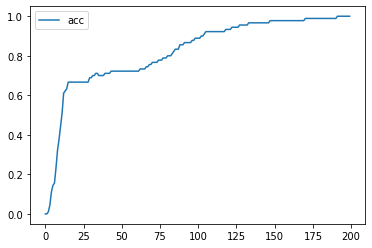

In [12]:
DataFrame({'acc': history.history['acc']}).plot()

## 抽出した特徴の可視化

In [22]:
layer_output = [model.get_layer('hidden').output]
model2 = models.Model(inputs=model.input, outputs=layer_output)

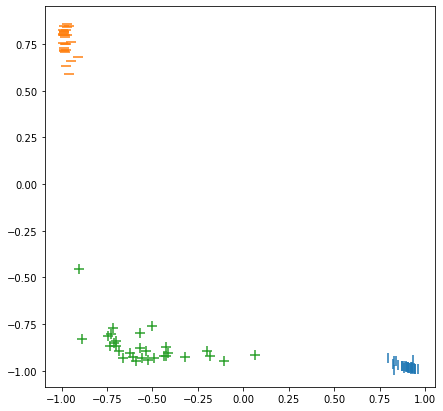

In [26]:
hidden_vals = model2.predict(images)

z1_vals = [[], [], []]
z2_vals = [[], [], []]

for hidden_val, label, in zip(hidden_vals, labels):
  label_num = np.argmax(label)
  z1_vals[label_num].append(hidden_val[0]) 
  z2_vals[label_num].append(hidden_val[1])

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(z1_vals[0], z2_vals[0], s=100, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=100, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=100, marker='+')

上の散布図を見ると横軸は「-」の有無を縦軸は「|」の有無を表しています。つまりz1が-に近づくと「-」が付与され+1に近づくと「-」が消えます。同様にz2が-に近づくと「|」が付与され+1に近づくと「|」が消えます。

畳み込みフィルターではあくまでも画像の特徴を抽出したけで、その後の拡張された出力層により画像の特徴毎に分類する作業が行われたことになります。